## Adding the required imports

In [108]:
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost

import joblib

import warnings


## Supress the warnings

In [109]:
warnings.filterwarnings(action="ignore")

## Load the dataset

In [110]:
df = pd.read_csv("../data/2022_Q1_OR_Utilization.csv")
df.head()

,index,Encounter ID,Date,OR Suite,Service,CPT Code,CPT Description,Booked Time (min),OR Schedule,Wheels In,Start Time,End Time,Wheels Out
0,0,10001,01/03/22,1,Podiatry,28110,"Partial ostectomy, fifth metatarsal head",90,01/03/22 07:00 AM,01/03/22 07:05 AM,01/03/22 07:32 AM,01/03/22 09:05 AM,01/03/22 09:17 AM
1,1,10002,01/03/22,1,Podiatry,28055,"Neurectomy, intrinsic musculature of foot",60,01/03/22 08:45 AM,01/03/22 09:48 AM,01/03/22 10:13 AM,01/03/22 11:01 AM,01/03/22 11:12 AM
2,2,10003,01/03/22,1,Podiatry,28297,Lapidus bunionectomy,150,01/03/22 10:00 AM,01/03/22 11:50 AM,01/03/22 12:20 PM,01/03/22 12:42 PM,01/03/22 12:58 PM
3,3,10004,01/03/22,1,Podiatry,28296,Bunionectomy with distal osteotomy,120,01/03/22 12:45 PM,01/03/22 01:29 PM,01/03/22 01:53 PM,01/03/22 02:50 PM,01/03/22 03:02 PM
4,4,10005,01/03/22,2,Orthopedics,27445,"Arthroplasty, knee, hinge prothesis",120,01/03/22 07:00 AM,01/03/22 07:15 AM,01/03/22 07:50 AM,01/03/22 09:38 AM,01/03/22 09:51 AM


In [111]:
## display the columns

In [112]:
df.columns

Index(['index', 'Encounter ID', 'Date', 'OR Suite', 'Service', 'CPT Code',
       'CPT Description', 'Booked Time (min)', 'OR Schedule', 'Wheels In',
       'Start Time', 'End Time', 'Wheels Out'],
      dtype='object')

## Exploratory data analysis

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   index              2172 non-null   int64 
 1   Encounter ID       2172 non-null   int64 
 2   Date               2172 non-null   object
 3   OR Suite           2172 non-null   int64 
 4   Service            2172 non-null   object
 5   CPT Code           2172 non-null   int64 
 6   CPT Description    2172 non-null   object
 7   Booked Time (min)  2172 non-null   int64 
 8   OR Schedule        2172 non-null   object
 9   Wheels In          2172 non-null   object
 10  Start Time         2172 non-null   object
 11  End Time           2172 non-null   object
 12  Wheels Out         2172 non-null   object
dtypes: int64(5), object(8)
memory usage: 220.7+ KB


## Basic cleaning and parsing

### Convert data/time to datetime

In [114]:
for col in ["Date", "Wheels In", "Wheels Out"]:
    df[col] = pd.to_datetime(df[col])

### Target variable actual case duratuon in minutes 

In [115]:
df["actual_duration_min"] = (df["Wheels Out"] - df["Wheels In"]).dt.total_seconds() / 60

### Compute overrun minutes based on booked time

In [116]:
df["overrun_min"] = (df["actual_duration_min"] - df["Booked Time (min)"]).clip(lower=0)

### Compute day of week and case hours

In [117]:
df["day_of_week"] = df["Date"].dt.dayofweek 
df["case_hour"] = df["Wheels In"].dt.hour

In [118]:
df[["Booked Time (min)", "actual_duration_min", "overrun_min"]].describe()

,Booked Time (min),actual_duration_min,overrun_min
count,2172.000000,2172.000000,2172.000000
mean,77.189227,79.697053,7.123849
std,30.430015,31.822390,8.729881
min,30.000000,19.000000,0.000000
25%,60.000000,62.000000,0.000000
50%,60.000000,73.000000,3.000000
75%,90.000000,96.000000,13.000000
max,180.000000,173.000000,42.000000


## Drop rows with missing key feilds

In [119]:

df_model = df.dropna(subset=["actual_duration_min", "Booked Time (min)", "Service", "CPT Code"]).copy()

num_features = ["Booked Time (min)", "day_of_week", "case_hour"]
cat_features = ["Service", "CPT Code"]

X = df_model[num_features + cat_features]
# Target variable
y = df_model["actual_duration_min"]

print("Rows used for modeling:", len(df_model))

# Splitting the training and testing dataset in 80 and 20 ratio
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42
)

# Data preprocessing
# The numerical features are passed thriough
# but the categorical featueres are ignored
preprocess = ColumnTransformer(
transformers=[
("num", "passthrough", num_features),
("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
]
)

Rows used for modeling: 2172


## Visualizations

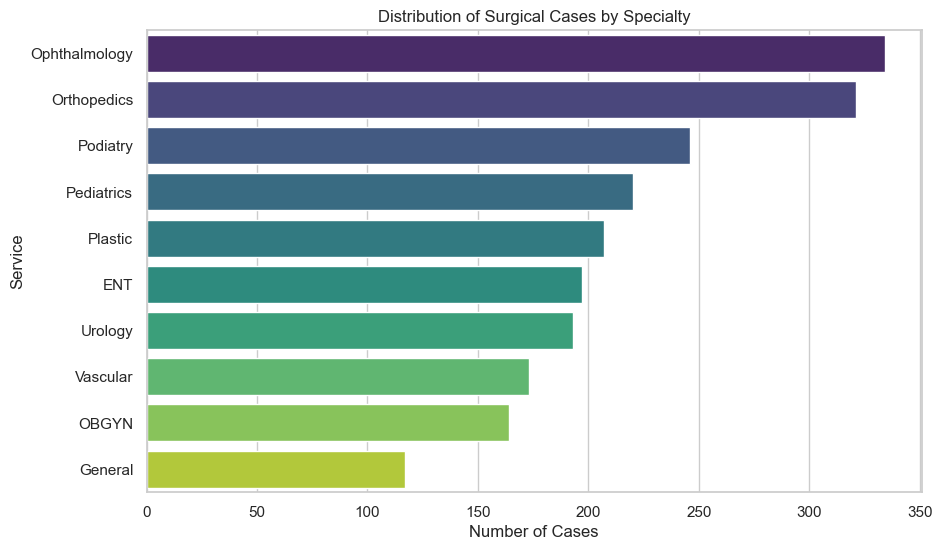

In [120]:
# Visualization 1: Distribution of Surgical Cases by Specialty
# This plot displays how many surgeries exist for each specialty.
# Set the visual style
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
# Count the occurrences of each Service
service_counts = df_model['Service'].value_counts()
sns.barplot(x=service_counts.values, y=service_counts.index, palette='viridis')

plt.title('Distribution of Surgical Cases by Specialty')
plt.xlabel('Number of Cases')
plt.ylabel('Service')
plt.show()

We do the above visualization check to understand the class imbalance . This help to understand if it is dominated by one or more specialities

## Visualization 2: Booked Time vs. Actual Duration

This scatter plot compares the time the hospital thought the surgery would take vs. how long it actually took.

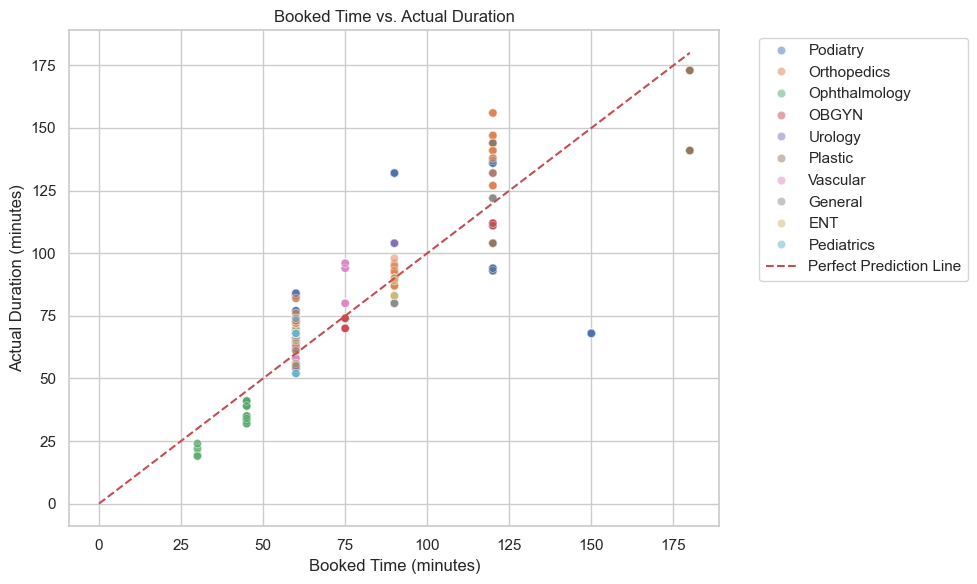

In [121]:
plt.figure(figsize=(10, 6))
# Scatter plot of Booked vs Actual
sns.scatterplot(x='Booked Time (min)', y='actual_duration_min', data=df_model, hue='Service', alpha=0.5)

# Add a "Perfect Prediction" line (Red Dashed)
# Points on this line mean the booking was exactly correct
max_val = max(df_model['Booked Time (min)'].max(), df_model['actual_duration_min'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction Line')

plt.title('Booked Time vs. Actual Duration')
plt.xlabel('Booked Time (minutes)')
plt.ylabel('Actual Duration (minutes)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()

## Random Forest Regressor

In [122]:
# Create the random forest regressor model using the basic configuration
rf = RandomForestRegressor(
n_estimators=400,
random_state=42,
n_jobs=-1,
)

# Create the pipeline that preprocess the data and fits the model
rf_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", rf)])

print("Training RandomForestRegressor...")
# Training the model
rf_pipe.fit(X_train, y_train)

# Testing the model
rf_pred = rf_pipe.predict(X_test)
# Calculating the mae and r2 score
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print(f"Random Forest MAE: {rf_mae:.2f} minutes")
print(f"Random Forest R^2: {rf_r2:.3f}")

Training RandomForestRegressor...
Random Forest MAE: 0.68 minutes
Random Forest R^2: 0.991


## XGBoost

In [123]:
# Create the XGBoost regression model with a basic configuration
xgb_model = xgboost.XGBRegressor(
objective="reg:squarederror",
n_estimators=400,
max_depth=4,
learning_rate=0.05,
subsample=0.8,
colsample_bytree=0.8,
random_state=42,
n_jobs=-1,
)

# Build a pipeline that preprocesses the data and then fits the XGBoost model
xgb_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", xgb_model)])

print("Training XGBRegressor...")
# Training the data
xgb_pipe.fit(X_train, y_train)

# Testing the data
xgb_pred = xgb_pipe.predict(X_test)

# MAE is calculated here
xgb_mae = mean_absolute_error(y_test, xgb_pred)

# R2 square is calculated here
xgb_r2 = r2_score(y_test, xgb_pred)

print(f"XGBoost MAE: {xgb_mae:.2f} minutes")
print(f"XGBoost R^2: {xgb_r2:.3f}")

Training XGBRegressor...
XGBoost MAE: 1.51 minutes
XGBoost R^2: 0.990


## Best model

In [124]:
if xgb_mae <= rf_mae:
    best_name = "XGBoost"
    best_pred = xgb_pred
    best_pipe = xgb_pipe
else:
    best_name = "RandomForest"
    best_pred = rf_pred
    best_pipe = rf_pipe

print(f"Best model based on MAE: {best_name}")

Best model based on MAE: RandomForest


## Save the best model

In [125]:
# save the chosel model to models folder
final_model_path = "../models/OptiOR.joblib"
# serializing the entire pipeline (preprocessing + model)
joblib.dump(
{
"pipeline": best_pipe,
"num_features": num_features,
"cat_features": cat_features,
},
final_model_path,
)
print("Saved best model (", best_name, ") to", final_model_path)

Saved best model ( RandomForest ) to ../models/OptiOR.joblib


## Predicted vs. Actual Performance

The model is very accurate for short surgeries (<60 mins) but consistently under-predicts long surgeries (>120 mins). This insight is critical for operational planning.

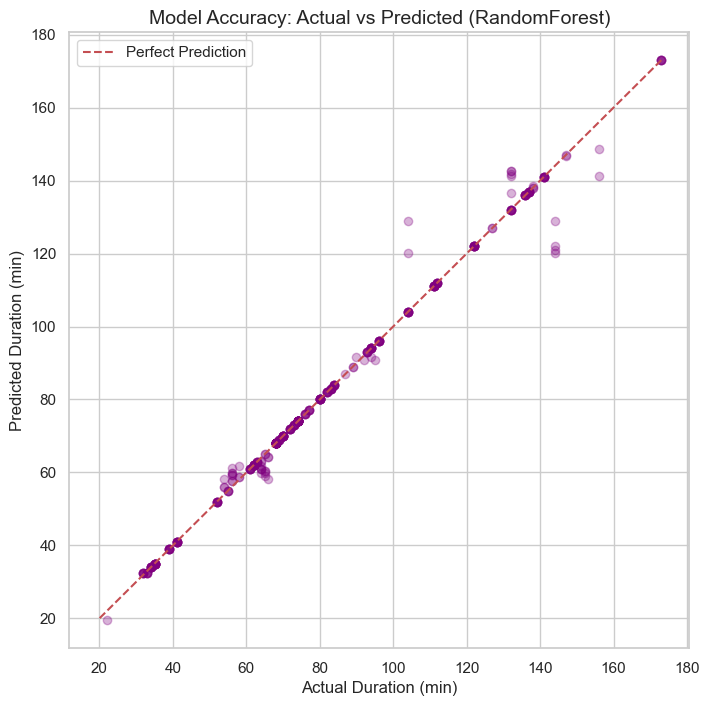

In [126]:
plt.figure(figsize=(8, 8))
# Plot the model's predictions against the real values
plt.scatter(y_test, best_pred, alpha=0.3, color='purple')

# Add the identity line
p1 = max(max(best_pred), max(y_test))
p2 = min(min(best_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'r--', label='Perfect Prediction')

plt.xlabel('Actual Duration (min)', fontsize=12)
plt.ylabel('Predicted Duration (min)', fontsize=12)
plt.title(f'Model Accuracy: Actual vs Predicted ({best_name})', fontsize=14)
plt.legend()
plt.show()

## Residuals (Error) Distribution

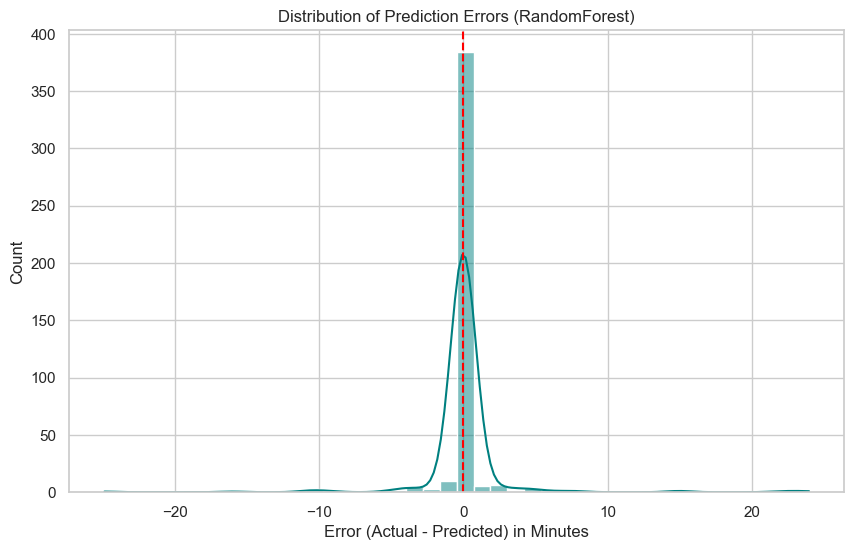

In [127]:
# Calculate the errors
residuals = y_test - best_pred

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='teal')
plt.axvline(x=0, color='red', linestyle='--')
plt.title(f'Distribution of Prediction Errors ({best_name})')
plt.xlabel('Error (Actual - Predicted) in Minutes')
plt.show()

In a perfect model, this "bell curve" should be centered exactly at 0.If the curve is shifted to the right, your model consistently under-estimates the time. If it's shifted left, it over-estimates.

## Feature Importance

In [1]:
import numpy as np

# 1. Extract feature names from the Preprocessing Step
# (This step digs into the pipeline to find the names generated by OneHotEncoding)
ohe = best_pipe.named_steps['preprocess'].named_transformers_['cat']
try:
    cat_feature_names = ohe.get_feature_names_out(cat_features)
    all_feature_names = num_features + list(cat_feature_names)
except AttributeError:
    # Fallback for older sklearn versions
    all_feature_names = num_features + list(ohe.get_feature_names(cat_features))

# 2. Extract Importances from the Model Step
importances = best_pipe.named_steps['model'].feature_importances_

# 3. Sort and Plot Top 10 Features
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(10, 6))
plt.title(f'Top 10 Drivers of Surgery Duration ({best_name})')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [all_feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

NameError: name 'best_pipe' is not defined

This we are doing to see if Booked Time is the most important feature for prediction